# OpenAI-Metadata-Tagger Prompt Tuning

This notebook documents the process of fine-tuning prompts that are used with GPT-3 based zero-shot learning. Speficically the OpenAI-Metadata-Tagger, provided in the Langchain framework, is used for this task. The OpenAI-Metadata-Tagger is a high level function that makes it easy to generate metadata for text documents by supplying a general prompt together with a schema describing the metadata that is supposed to be generated by the language model.

## Import Libraries

To run this code the libraries that are imported in the code cell below have to be installed. Furthermore, for running the code an OpenAI account has to be made to access the API. The API key has to be placed in a .env file (in the format: OPENAI_API_KEY="...") which is also read in the cell below.

In [98]:
import pandas as pd
import numpy as np
import math
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from langchain_community.document_loaders import DataFrameLoader
from langchain.chat_models import ChatOpenAI
from langchain.document_transformers.openai_functions import create_metadata_tagger
from langchain.prompts import ChatPromptTemplate

#pd.set_option('display.max_colwidth', None)

_ = load_dotenv(find_dotenv())

## Load Data

In [3]:
#all_comments = pd.read_parquet("data/scored_comments.parquet.gzip")

gold_standard_comments = pd.read_csv("data/gold_standard.csv")
# add 200 to each row ID to match annotations
gold_standard_comments["rowid"] += 200
gold_standard_comments = gold_standard_comments.set_index("rowid")

gold_standard_annotations = pd.read_csv("data/gs_annotated.csv")
# fix inconsistent column labelling
gold_standard_annotations = gold_standard_annotations.rename(columns={"comment_id": "rowid"})
gold_standard_annotations = gold_standard_annotations.set_index("rowid")

train_set_ids = pd.read_csv("data/train_sample_rowids.csv")
train_set_ids = train_set_ids["rowid"]
train_set_ids = train_set_ids.sort_values()

In [6]:
# show value counts
for col in gold_standard_annotations.columns:
    display(gold_standard_annotations[col].value_counts())

coder_id
AM    200
AT    200
es    200
fv    200
NC    200
fd    200
Name: count, dtype: int64

excl_other
0    1120
1      80
Name: count, dtype: int64

ref_persona
1.0    901
0.0    287
2.0      1
Name: count, dtype: int64

sentiment_overall
 1.0    609
 0.0    358
-1.0     44
Name: count, dtype: int64

ambiguity
 0.0    821
 1.0    188
-1.0      2
Name: count, dtype: int64

comprehension
0.0    828
1.0    183
Name: count, dtype: int64

memory_relate
0.0    950
1.0     61
Name: count, dtype: int64

self_relate
0.0    878
1.0    132
Name: count, dtype: int64

evaluation
 1.0    571
 0.0    430
-1.0     10
Name: count, dtype: int64

future
0.0    782
1.0    228
Name: count, dtype: int64

sympathy_antipathy
0.0    580
1.0    431
Name: count, dtype: int64

empathy_counterempathy
0.0    935
1.0     74
Name: count, dtype: int64

emotion_release
0.0    942
1.0     69
Name: count, dtype: int64

In [7]:
# ref_persona contains a 2
# replace that with a 1
gold_standard_annotations["ref_persona"] = gold_standard_annotations["ref_persona"].replace(2, 1)

# ambiguity contains two -1s
# replace them with  1s
gold_standard_annotations["ambiguity"] = gold_standard_annotations["ambiguity"].replace(-1, 1)

# evaluation contains several -1s
# replace them with 1s
gold_standard_annotations["evaluation"] = gold_standard_annotations["evaluation"].replace(-1, 1)

## Split Up Data Into Training and Testing Sets

In [8]:
test_set_ids = pd.Series(np.setdiff1d(gold_standard_annotations.index, train_set_ids))

gold_standard_comments_train = gold_standard_comments.loc[train_set_ids]
gold_standard_comments_test = gold_standard_comments.loc[test_set_ids]

gold_standard_annotations_train = gold_standard_annotations.loc[train_set_ids]
gold_standard_annotations_test = gold_standard_annotations.loc[test_set_ids]

In [9]:
print(f"training set size: {len(gold_standard_annotations_train)}")
print(f"testing set size: {len(gold_standard_annotations_test)}")

training set size: 300
testing set size: 900


## Create Metadata Tagger

The metadata tagger should be able to do the same annotation process that we did manually. It should tag the comments for the following attributes:

**Exclusion Criteria**

| attribute              | description
|------------------------|------------
| excl_other             | Is the comment written in a different language than English or is it not comprehensible for other reasons?
| ref_persona            | Does the person refer to a persona? Exclude if the person is clearly not in the video.

**Sentiment**

| attribute              | description
|------------------------|------------
| sentiment_overall      | Is the overall sentiment of the comment positive or negative?
| ambiguity              | Is the sentiment ambiguous?

**Cognitive**

| attribute              | description
|------------------------|------------
| comprehension          | Does the commenter reference being (not) able to understand the situation / motivation of the persona?
| memory_relate          | Commenter relates something that a person from the video does or says to a memory of a situation or other persons in his life. Do not code if something that a person from the video does or says is linked with the commenters self (e.g., “I was in a similar situation”, “I know this situation”).
| self_relate            | Does the commenter make a comparison between themselves and another person? (e.g., “I can (not) identify with the person”; “Person is (dis)similar to me/my group”)
| evaluation             | Does the commenter judge another person or another person’s actions (in a good or a bad way)?
| future                 | Does the commenter reference future situations / motivations of the persona?

**Affective**

| attribute              | description
|------------------------|------------
| sympathy_antipathy     | Does the commenter express positive or negative feelings towards the person? (e.g., “I am happy for you”, “I hate you”).
| empathy_counterempathy | Does the commenter express experiencing the same emotions as the person? (e.g., “I cried when you cried”, “Your laugh made me happy”).
| emotion_release        | Did the mood or emotions of the persona have a significant impact on the commenter to the extent that they were deeply absorbed and almost felt the same emotions as the persona? (Yes/No).

In [63]:
def docs_to_df(docs):
    """function for retransforming metadata of documents into dataframe"""
    
    attributes = list(docs[0].metadata.keys())
    df = pd.DataFrame(columns=attributes)
    for doc in docs:
        df = df._append(
            doc.metadata,
            ignore_index=True
        )
    df = df.set_index("rowid")
    df = df.drop(columns="comment_id")
    df.columns = [col + "_pred" for col in df.columns]

    return df


def analyze_predictions(transformed_docs, gold_standard_annotations, gold_standard_comments, display_predictions=True, display_confusion_matrices=False):
    """function for shortly analyzing predictions"""

    # extract predictions from transformed documents metadata
    preds_df = docs_to_df(transformed_docs)
    preds_df = preds_df.astype(int)
    # add gold standard annotations
    attributes = [col[:-5] for col in preds_df.columns]
    preds_df = preds_df.join(gold_standard_annotations[attributes])
    # add comments
    preds_df = preds_df.join(gold_standard_comments["comment"])

    # print accuracy values per attribute
    for attribute in attributes:
        pred_attribute_col = f"{attribute}_pred"
        # only take values where both predicted and true values are not NaN
        acc = accuracy_score(
            preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][attribute],
            preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][pred_attribute_col]
        )
        print(f"Accuracy {attribute}: {acc}")

    # display dataframe if specified
    if display_predictions:
        display(preds_df)

    # display confusion matrices if specified
    if display_confusion_matrices:
        for attribute in attributes:
            pred_attribute_col = f"{attribute}_pred"
            n_classes = max(len(preds_df[attribute].dropna().unique()), len(preds_df[pred_attribute_col].dropna().unique()))
            labels = [-1, 0, 1] if n_classes == 3 else [0, 1]
            cm = confusion_matrix(
                preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][attribute],
                preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][pred_attribute_col],
                labels=labels
            )
            cm_plot = ConfusionMatrixDisplay(cm, display_labels=labels)
            cm_disp = cm_plot.plot()
            cm_disp.ax_.set_title(f"Confusion Matrix - {attribute}")

In [124]:
def docs_to_df(docs):
    """function for retransforming metadata of documents into dataframe"""
    
    attributes = list(docs[0].metadata.keys())
    df = pd.DataFrame(columns=attributes)
    for doc in docs:
        df = df._append(
            doc.metadata,
            ignore_index=True
        )
    df = df.set_index("rowid")
    df = df.drop(columns="comment_id")
    df.columns = [col + "_pred" for col in df.columns]

    return df


def analyze_predictions(transformed_docs, gold_standard_annotations, gold_standard_comments, display_predictions=True, display_confusion_matrices=False):
    """function for shortly analyzing predictions"""

    # extract predictions from transformed documents metadata
    preds_df = docs_to_df(transformed_docs)
    preds_df = preds_df.astype(int)
    # add gold standard annotations
    attributes = [col[:-5] for col in preds_df.columns]
    preds_df = preds_df.join(gold_standard_annotations[attributes])
    # add comments
    preds_df = preds_df.join(gold_standard_comments["comment"])

    # print accuracy values per attribute
    for attribute in attributes:
        pred_attribute_col = f"{attribute}_pred"
        # only take values where both predicted and true values are not NaN
        acc = accuracy_score(
            preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][attribute],
            preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][pred_attribute_col]
        )
        print(f"Accuracy {attribute}: {acc}")

    # display dataframe if specified
    if display_predictions:
        display(preds_df)

    # display confusion matrices if specified
    if display_confusion_matrices:
        plot_rows = math.ceil(len(attributes) / 2)
        fig, axs = plt.subplots(nrows=plot_rows, ncols=2, figsize=(6, 3*plot_rows), tight_layout=True)
        for i, attribute in enumerate(attributes):
            pred_attribute_col = f"{attribute}_pred"
            n_classes = max(len(preds_df[attribute].dropna().unique()), len(preds_df[pred_attribute_col].dropna().unique()))
            labels = [-1, 0, 1] if n_classes == 3 else [0, 1]
            cm = confusion_matrix(
                preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][attribute],
                preds_df[preds_df[[attribute, pred_attribute_col]].isna().sum(axis=1) == False][pred_attribute_col],
                labels=labels
            )
            cm_plot = ConfusionMatrixDisplay(cm, display_labels=labels)
            cm_disp = cm_plot.plot(ax=axs[i//2, i%2] if plot_rows > 1 else axs[i%2])
            cm_disp.ax_.set_title(f"Confusion Matrix\n{attribute}")
        if len(attributes) % 2 == 1:
            fig.delaxes(axs[plot_rows-1, 1])

### Exclusion Criteria

In [10]:
# load the comments into a list of langchain documents
# this is necessary to process the documents with the metadata tagger
train_loader = DataFrameLoader(gold_standard_comments_train.reset_index(), page_content_column="comment")
train_docs = train_loader.load()
# take a smaller sample for initial testing of prompts
train_docs_sample = train_docs[:20]

In [11]:
# tagging exclusion criteria attributes

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

excl_crit_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Extract the properties in relation to that comment. Output 1 if the condition is fullfilled and 0 if it is not.

{input}
"""
)

schema = {
    "properties": {
        "excl_other": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the comment written in any other language than English or is it incomprehensible for other reasons?"
        },
        "ref_persona": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does this comment reference a person? If the comment references another person that is clearly not in the video (e.g. another commenter) output False."
        }
    },
    "required": ["excl_other", "ref_persona"]
}

excl_crit_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=excl_crit_prompt)

train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs_sample)

/home/felix/anaconda3/envs/chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:115: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use langchain_openai.ChatOpenAI instead.
  warn_deprecated(


In [31]:
# analyze results
analyze_predictions(train_docs_excl_crit_preds, gold_standard_annotations, gold_standard_comments)

Accuracy excl_other: 1.0
Accuracy ref_persona: 0.45


,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,0,0,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,0,0,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,0,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,0,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,0,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,0,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,0,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,0,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


The excl_other attribute is 0 for every comment in the sample. While there are two cases in the gold standard where this attribute is set to 1, it is not clear why the comment should be excluded. For that reason the performance on the excl_other attribute does not seem to be bad.

The ref_persona attribute is not tagged correctly in most cases. The LLM outputs 0 for most comments. The prompt is adjusted until the results are better.

In [32]:
# tagging exclusion criteria attributes

excl_crit_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Analyze the comments to find out if they are comprehensible and if they reference a person. \
Output 1 if the condition is fullfilled and 0 if it is not. \

A comment can refer to one or multiple persons in the YouTube video. This is often the case when names are used. \
A comment can also refer on or mor persons by speaking directly to them. \
In the special case that a comment refers to a person that is clearly not in the video (e.g. a well known celebrity) output 0.

{input}
"""
)

schema = {
    "properties": {
        "excl_other": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the comment written in any other language than English or is it incomprehensible for other reasons?"
        },
        "ref_persona": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does this comment reference one or more persons?"
        }
    },
    "required": ["excl_other", "ref_persona"]
}

excl_crit_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=excl_crit_prompt)

train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs_sample)

In [34]:
# analyze results
analyze_predictions(train_docs_excl_crit_preds, gold_standard_annotations, gold_standard_comments)

Accuracy excl_other: 0.75
Accuracy ref_persona: 0.8


,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,1,1,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,1,1,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,1,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,1,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,1,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,1,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,0,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,1,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


The results for the ref_persona attribute are much better now. There are still inconsistencies between the predicted and gold standard value but when looking at these individual cases the outputted values of the LLM are not obviously wrong and sometimes seem even more reasonable.
 
Changing the prompt to better capture the ref_persona attribute also changed the output for the excl_other_pred attribute. The LLM sets this attribute to True in some cases where the comments should not be excluede. The prompt is further refined with the hope to eliminate this behaviour while still having good outputs for the ref_persona attribute.

In [35]:
# tagging exclusion criteria attributes

excl_crit_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Analyze the comments to find out if they are comprehensible and if they reference a person. \
Output 1 if the condition is fullfilled and 0 if it is not. \

If a comment is written in any language other than English set the excl_other attribute to 1. \
If a comment does not contain text or it is impossible to understand it set this attribute to 1 as well. \
In any other case set it to 0. \

A comment can refer to one or multiple persons in the YouTube video. This is often the case when names are used. \
A comment can also refer on or mor persons by speaking directly to them. \
In the special case that a comment refers to a person that is clearly not in the video (e.g. a well known celebrity) output 0.

{input}
"""
)

schema = {
    "properties": {
        "excl_other": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the comment incomprehensible?"
        },
        "ref_persona": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does this comment reference one or more persons?"
        }
    },
    "required": ["excl_other", "ref_persona"]
}

excl_crit_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=excl_crit_prompt)

train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs_sample)

In [36]:
# analyze results
analyze_predictions(train_docs_excl_crit_preds, gold_standard_annotations, gold_standard_comments)

Accuracy excl_other: 0.95
Accuracy ref_persona: 0.9


,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,0,1,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,0,1,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,1,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,1,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,1,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,1,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,1,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,0,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


In [37]:
# analyze results

train_excl_crit_preds = docs_to_df(train_docs_excl_crit_preds)
train_excl_crit_preds[["excl_other_pred", "ref_persona_pred"]] = train_excl_crit_preds[["excl_other_pred", "ref_persona_pred"]].astype(int)
# add gold standard annotations
train_excl_crit_preds = train_excl_crit_preds.join(gold_standard_annotations[["excl_other", "ref_persona"]])
# add comments
train_excl_crit_preds = train_excl_crit_preds.join(gold_standard_comments["comment"])


display(train_excl_crit_preds)

print("Accuracy excl_other: ", accuracy_score(train_excl_crit_preds["excl_other_pred"], train_excl_crit_preds["excl_other"]))
print("Accuracy ref_persona: ", accuracy_score(train_excl_crit_preds["ref_persona_pred"], train_excl_crit_preds["ref_persona"]))

,excl_other_pred,ref_persona_pred,excl_other,ref_persona,comment
rowid,,,,,
202,0,1,0,1.0,I'm so excited for you both! You both are going to be such an amazing parents ❤❤
203,0,1,0,1.0,"congrat to the both of you and may the Lord keep blessing you both on this new journey and may the Lord but his hands over baby protect him or her and keep baby safe,strong and healthy"
210,0,1,0,1.0,"U guys are gonna be the coolest parents,,, I’m actually so proud of you guys😍❤️😍"
212,0,1,0,1.0,This is so phenomenal! Your entire family is so talented and silly and just wonderful.
214,0,1,0,1.0,I’m not Hispanic but I am arab our last name is very odd lol the whole story about it is extremely long and complicated lol so I completely understand you guys. To make it even more complicated our cousins have the same last name but just changed one letter 😂
216,0,1,0,1.0,Give your beautichian's info for those of us that live in Vegas Please 😁
224,0,1,0,1.0,"You need to trash all those vitamins and etc., on that container"
225,0,0,0,0.0,Dude man dude man ...when is the next release then was at work running it up so I get 2 pair 1 for collection 1 for rockN ...what?? 6months to year 🤦🏿‍♂️🤦🏿‍♂️🤦🏿‍♂️
227,0,1,0,1.0,"History in the making, proud of you CJ. Lexi is a keeper shout to her for the best birthday gift🎁. Shout out to everyone on the trip. 💯💯💯💯💯💯💯💯💯💯"


Accuracy excl_other:  0.95
Accuracy ref_persona:  0.9


The outputs for the excl_other_pred attribute improved. The outputs for the ref_persona_pred also change in one case, where it now classifies the comment as it is classified in the gold standard. Overall, the performance seems acceptable now. The same prompt is now used to classify the whole training set and evaluate the performance.

In [38]:
train_docs_excl_crit_preds = excl_crit_document_transformer.transform_documents(train_docs)

Accuracy excl_other: 0.8966666666666666
Accuracy ref_persona: 0.7993311036789298


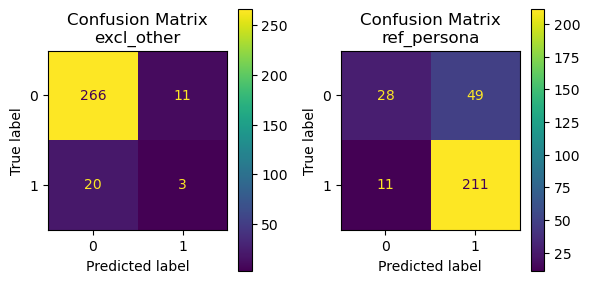

In [125]:
# analyze results
excl_crit_preds_df = analyze_predictions(
    train_docs_excl_crit_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_predictions=False,
    display_confusion_matrices=True
)

...

### Sentiment

In [66]:
# tagging sentiment attributes

sentiment_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG. \
Determine the overall sentiment of the comment. If the sentiment is positive use 1, if it is negative -1 and 0 if it is neutral. \

Some comments might have an ambigous sentiment, for example if they are partly positive and partly negative. \
If the sentiment is ambigous output a 1 for ambiguity. If it is not ambiguous output a 0 for ambiguity. \

{input}
"""
)

schema = {
    "properties": {
        "sentiment_overall": {
            "type": "string",
            "enum": ["-1", "0", "1"],
            "description": "Sentiment of the comment"
        },
        "ambiguity": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Is the sentiment ambiguous?"
        }
    },
    "required": ["sentiment_overall", "ambiguity"]
}

sentiment_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=sentiment_prompt)

train_docs_sentiment_preds = sentiment_document_transformer.transform_documents(train_docs)

Accuracy sentiment_overall: 0.7058823529411765
Accuracy ambiguity: 0.9411764705882353


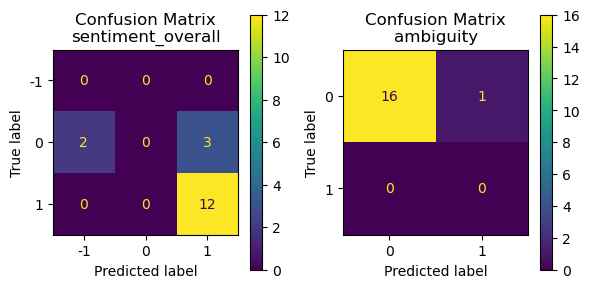

In [126]:
analyze_predictions(
    train_docs_sentiment_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_confusion_matrices=True,
    display_predictions=False
)

### Cognitive

In [75]:
# tagging cognitive attributes

cognitive_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG. \
Determine the following attributes which are related to the cognitive response of the commenter to the video. \

The attribute comprehension indicates if the commenter somehow expresses being able to understands the situation \
or motivation of a person from the video. If you think this applies to the comment output 1 otherwise 0. \

The attribute memory_relate indicates if the commenter relates something that a person from the video does or says \
to a memory of a situation or to other persons in his or her life. If you think this applies to the comment output 1 otherwise 0. \

The attribute self_relate indicates if the commenter relates a person to himself or herself. \
This could for example be the case if the commenter makes a comparison between himself / herself and a person from the video. \
If you think this applies to the comment output 1 otherwise 0. \

The attribute evaluation indicates if the commenter evaluates or judges a person from the video or his / her behaviour. \
For example the commenter might reference a positive aspect of the person, give a compliment or critisize something about the person. \
It does not matter if the judgement is good or bad. If you think this applies to the comment output 1 otherwise 0. \

The attribute future indicates if the comment references future situations or motivations of a person from the video. \
If you think this applies to the comment output 1 otherwise 0. \

{input}
"""
)

schema = {
    "properties": {
        "comprehension": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter reference being (not) able to understand the situation or motivation of the persona?"
        },
        "memory_relate": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter relate something that a person from the video does or says to a memory of a situation or other persons in his life."
        },
        "self_relate": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter make a comparison between themselves and another person?"
        },
        "evaluation": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter judge another person or another person’s actions (in a good or a bad way)?"
        },
        "future": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter reference future situations or motivations of the persona?"
        }
    },
    "required": ["comprehension", "memory_relate", "self_relate", "evaluation", "future"]
}

cognitive_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=cognitive_prompt)

train_docs_cognitive_preds = cognitive_document_transformer.transform_documents(train_docs)

Accuracy comprehension: 0.749003984063745
Accuracy memory_relate: 0.9083665338645418
Accuracy self_relate: 0.701195219123506
Accuracy evaluation: 0.6772908366533864
Accuracy future: 0.668


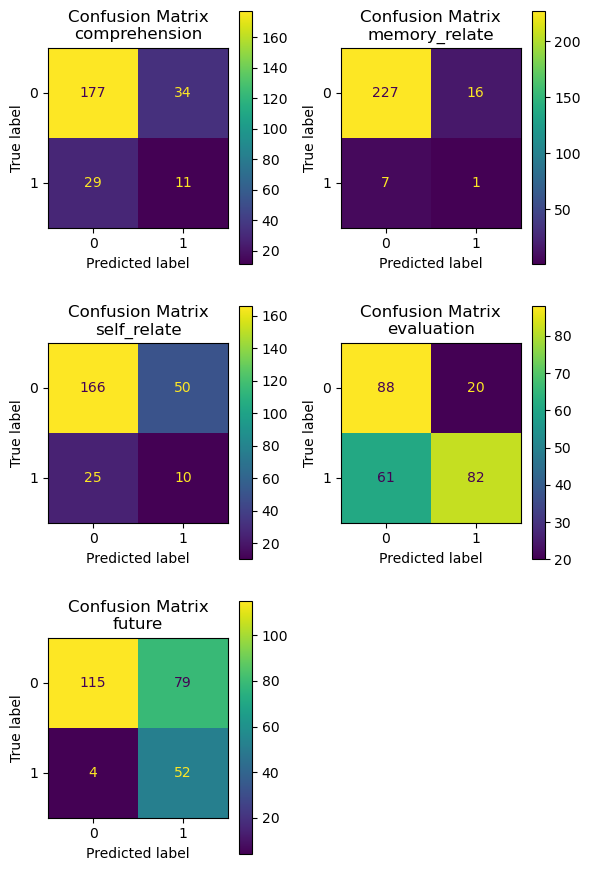

In [127]:
analyze_predictions(
    train_docs_cognitive_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_predictions=False,
    display_confusion_matrices=True
)

### Affective

In [93]:
# tagging affective attributes

affective_prompt = ChatPromptTemplate.from_template(
    """The following document is a YouTube comment that was posted under a YouTube video of a family VLOG.
Determine the following attributes which are related to the cognitive response of the commenter to the video. \

The attribute sympathy_antipathy indicates if the commenter expresses positive or negative feelings \
towards a person from the video on an emotional level. If you think this applies to the comment output 1 otherwise 0. \

The attribute empathy_counterempathy indicates if the commenter expresses feeling the same emotions as \
a person from the video. If you think this applies to the comment output 1 otherwise 0. \

The attribute emotion_release indicates if the commenter states that the mood or emotion of a person from the video \
had a significant impact on the commenter to the extent that they were deeply absorbed and almost felt the same \
emotion. If you think this applies to the comment output 1 otherwise 0. \

{input}
"""
)

schema = {
    "properties": {
        "sympathy_antipathy": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter express positive or negative feelings towards the person?"
        },
        "empathy_counterempathy": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Does the commenter express experiencing the same emotions as the person?"
        },
        "emotion_release": {
            "type": "string",
            "enum": ["0", "1"],
            "description": "Did the mood or emotions of the persona have a significant impact on the commenter to the extent that they were deeply absorbed and almost felt the same emotions as the persona?"
        },
    },
    "required": ["sympathy_antipathy", "empathy_counterempathy", "emotion_release"]
}

affective_document_transformer = create_metadata_tagger(metadata_schema=schema, llm=llm, prompt=affective_prompt)

train_docs_affective_preds = affective_document_transformer.transform_documents(train_docs)

Accuracy sympathy_antipathy: 0.5378486055776892
Accuracy empathy_counterempathy: 0.792
Accuracy emotion_release: 0.8844621513944223


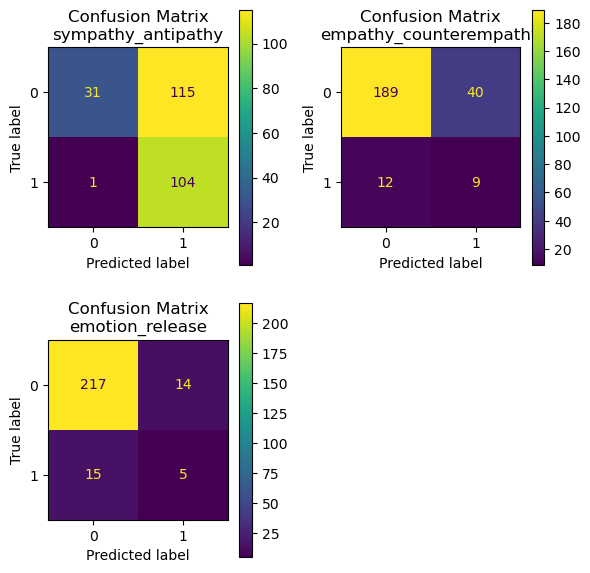

In [128]:
analyze_predictions(
    train_docs_affective_preds,
    gold_standard_annotations,
    gold_standard_comments,
    display_predictions=False,
    display_confusion_matrices=True
)